In [ ]:
!pip install chromadb --quiet
!wget https://raw.githubusercontent.com/llpfdc/HackUPC2024/main/utilities4.py

--2024-05-05 01:51:50--  https://raw.githubusercontent.com/llpfdc/HackUPC2024/main/utilities4.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3407 (3.3K) [text/plain]
Saving to: ‘utilities4.py.2’

utilities4.py.2     100%[===================>]   3.33K  --.-KB/s    in 0s      

2024-05-05 01:51:50 (33.8 MB/s) - ‘utilities4.py.2’ saved [3407/3407]



In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# InditexTech

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

from utilities4 import links_to_data_and_labels, preprocess_dataframe

## Read data

In [ ]:
def concat_columns(dataframe, bConcat=False):
  if bConcat:
    row_images = pd.concat([dataframe['IMAGE_VERSION_1'],
                            dataframe['IMAGE_VERSION_2'],
                            dataframe['IMAGE_VERSION_3']],
                           ignore_index=True)
  else:
    dataframe = dataframe.drop(columns=['IMAGE_VERSION_2', 'IMAGE_VERSION_3'])
    row_images = dataframe['IMAGE_VERSION_1']

  dataframe = pd.DataFrame({'images': row_images})
  return dataframe

def preprocess_dataframe(dataframe, bConcat=False, size=100):
  dataframe = dataframe.dropna()

  dataframe = concat_columns(dataframe, bConcat=bConcat)

  dataframe = dataframe[:size]

  return dataframe

In [ ]:
url = 'https://github.com/llpfdc/HackUPC2024/blob/main/inditextech_hackupc_challenge_images.csv?raw=true'
df = pd.read_csv(url)

df = preprocess_dataframe(df, bConcat=False, size=40000)

train_df = df[0:2000]
test_df = df[2000:3000]
eval_df = df[3000:]

print(len(train_df))
print(len(test_df))
print(len(eval_df))

2000
1000
37000


## Load ResNet-50

In [ ]:
import torchvision.transforms as transforms
import torchvision.models as models

# Load pre-trained ResNet model
resnet50_model = models.resnet50(weights=True)
resnet50_model = torch.nn.Sequential(*list(resnet50_model.children())[:-1])

# Model to eval mode
resnet50_model.eval();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Load model with transfer learning (ResNet-50)

In [ ]:
custom_model = models.resnet50(weights=True)
torch.save(custom_model, 'resnet50_pretrained.pt')
custom_model = torch.load('resnet50_pretrained.pt')

custom_model = torch.nn.Sequential(*list(custom_model.children())[:-1])
custom_model.cpu();
custom_model.load_state_dict(torch.load('/content/drive/MyDrive/model_weights/custom_resnet50_weights2.h5'))

<All keys matched successfully>

## Define model with transfer learning (ResNet-50)

Don't run this!

In [ ]:
model = models.resnet50(weights=True)
torch.save(model, 'resnet50_pretrained.pt')
model = torch.load('resnet50_pretrained.pt')

# Disable gradients on all model parameters to freeze the weights
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected resnet layer with a 2 fc layer network and sigmoid output
model.fc = nn.Sequential(nn.Linear(2048, 256),
                         nn.ReLU(),
                         nn.Linear(256, 1),
                         nn.Sigmoid())

# Defreeze final layers
for param in model.fc.parameters():
    param.requires_grad = True

# Unfreeze the last few layers of the model
for param in model.layer4.parameters():
    param.requires_grad = True

### DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, list_of_tensors):
        self.data = list_of_tensors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img,label = self.data[idx]
        return img,label

# Create custom dataset
data, labels = links_to_data_and_labels(train_df)
data = [(x, y) for x, y in zip(data, labels)]
custom_dataset = CustomDataset(data)

# Create DataLoader
batch_size = 32
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

### Train model

In [ ]:
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.AdamW(model.parameters(), lr=0.000025, weight_decay=50)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [1, 2, 6], gamma=0.5)

# Training and validation loop
model.cuda()
n_epochs = 128
train_losses = []

for epoch in range(1, n_epochs+1):
    start = time.time()
    current_lr = scheduler.get_last_lr()[0]

    # keep track of training loss
    train_loss = 0.0

    # Stop training the convolutional layers after a certain point
    if epoch > 3:
        for param in model.layer4.parameters():
            param.requires_grad = False

    ###################
    # train the model #
    ###################
    # put in training mode (enable dropout)
    model.train()
    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        images = torch.squeeze(images)
        output = model(images)

        # calculate the batch loss
        labels = labels.float()
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        # update training loss
        train_loss += loss.item()

    train_loss = math.sqrt(train_loss/len(dataloader.sampler))
    train_losses.append(dataloader)

    # increment learning rate decay
    scheduler.step()
    print('Epoch: {}, time: {:.1f}s, lr: {:.7f} \tTraining Loss: {:.3f}'.format(
        epoch, float(time.time() - start), current_lr, train_loss))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, time: 8.0s, lr: 0.0000250 	Training Loss: 2.550
Epoch: 2, time: 7.9s, lr: 0.0000125 	Training Loss: 2.478
Epoch: 3, time: 8.0s, lr: 0.0000063 	Training Loss: 2.477
Epoch: 4, time: 5.9s, lr: 0.0000063 	Training Loss: 2.477
Epoch: 5, time: 6.0s, lr: 0.0000063 	Training Loss: 2.476
Epoch: 6, time: 5.9s, lr: 0.0000063 	Training Loss: 2.479
Epoch: 7, time: 6.0s, lr: 0.0000031 	Training Loss: 2.473
Epoch: 8, time: 6.0s, lr: 0.0000031 	Training Loss: 2.474
Epoch: 9, time: 6.0s, lr: 0.0000031 	Training Loss: 2.477
Epoch: 10, time: 6.0s, lr: 0.0000031 	Training Loss: 2.469
Epoch: 11, time: 6.0s, lr: 0.0000031 	Training Loss: 2.475
Epoch: 12, time: 6.1s, lr: 0.0000031 	Training Loss: 2.477
Epoch: 13, time: 6.1s, lr: 0.0000031 	Training Loss: 2.476
Epoch: 14, time: 6.1s, lr: 0.0000031 	Training Loss: 2.467
Epoch: 15, time: 6.1s, lr: 0.0000031 	Training Loss: 2.478
Epoch: 16, time: 6.1s, lr: 0.0000031 	Training Loss: 2.475
Epoch: 17, time: 6.1s, lr: 0.0000031 	Training Loss: 2.477
Epoch:

In [ ]:
custom_model = torch.nn.Sequential(*list(custom_model.children())[:-1])
custom_model.cpu();

### Save model weights

In [ ]:
#path = '/content/drive/custom_resnet50_weights.h5'
torch.save(model.state_dict(), 'custom_resnet50_weights2.h5')

In [ ]:
model.load_state_dict(torch.load('custom_resnet50_weights2.h5'))

NameError: name 'custom_model' is not defined

## Load vector embeddings

In [ ]:
import chromadb

chroma_client = chromadb.PersistentClient(path="/content/Shared drives/HackUpc2024/Database")

resnet50_model_collection = chroma_client.get_or_create_collection(name="resnet50_model_embeddings")
custom_model_collection = chroma_client.get_or_create_collection(name="custom_model_embeddings")

## Generate embeddings

In [ ]:
def preprocess_image(img):
    ''' Resize image '''
    base_width = 64
    wpercent = (base_width / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))

    return img.resize((base_width, hsize), Image.Resampling.LANCZOS)


def image_to_tensor(image):
    ''' Convert image to tensor feasible by ResNet-50 '''
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)

    return image.unsqueeze(0)

In [ ]:
def url_to_Image(url):
  ''' Convert from url to image '''
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  return img

def get_embedding(model, image):
    ''' Generate embedding from image '''
    image = preprocess_image(image)
    image_tensor = image_to_tensor(image)
    #image_tensor = image_tensor.to('cuda')
    with torch.no_grad():
         features = model(image_tensor)
         #features = features.cpu()
    embedding = features.squeeze().numpy()
    result = [float(emb) for emb in embedding]

    return result

def generate_new_link(link):
  ''' Generate new link from old link '''
  prefix = "https://sttc-stage-zaraphr.inditex.com"

  parts = link.split("/")
  half_link = parts.index("photos")
  new_url = "/".join(parts[half_link:])
  new_link = prefix + '/' + new_url

  return new_link

def generate_embedding(model, index, row):
  link = row['images']
  embedding = ""
  try:
    image = url_to_Image(link)
    embedding = get_embedding(model, image)
  except:
    link = generate_new_link(link)
    image = url_to_Image(link)
    if image:
      embedding = get_embedding(model, image)

  return embedding

def add_embedding_to_collection(collection, row, index, embedding):
  collection.add(
      embeddings=[embedding],
      documents=[row['images']],
      ids=str(index)
      )

### Embeddings for ResNet-50 model

In [ ]:
from tqdm import tqdm

collection = resnet50_model_collection
model = resnet50_model

embeddings = []
failed_links = []

for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
  # Get embedding list for index in Collection (if exists)
  embedding_list = collection.get(str(index))['documents']

  if embedding_list == []:
    # Embedding not exist in ChromaDB
    embedding = generate_embedding(model, index, row)
    if embedding:
      # Embedding could be generated
      add_embedding_to_collection(collection, row, index, embedding)
      embeddings.append(embedding)
    else:
      # Embedding could not be generated
      failed_links.append(row['images'])
  else:
    # Embedding already exist in ChromaDB
    embedding = embedding_list[0]
    embeddings.append(embedding)

# Drop rows where images could not get retreated
test_df = test_df.drop(index=failed_links)
test_df['embedding'] = embeddings

100%|██████████| 1000/1000 [00:05<00:00, 198.99it/s]


In [ ]:
from tqdm import tqdm

collection = custom_model_collection
model = custom_model

embeddings = []
failed_links = []

for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
  # Get embedding list for index in Collection (if exists)
  embedding_list = collection.get(str(index))['documents']

  if embedding_list == []:
    # Embedding not exist in ChromaDB
    embedding = generate_embedding(model, index, row)
    if embedding:
      # Embedding could be generated
      add_embedding_to_collection(collection, row, index, embedding)
      embeddings.append(embedding)
    else:
      # Embedding could not be generated
      failed_links.append(row['images'])
  else:
    # Embedding already exist in ChromaDB
    embedding = embedding_list[0]
    embeddings.append(embedding)

# Drop rows where images could not get retreated
test_df = test_df.drop(index=failed_links)
test_df['embedding'] = embeddings

100%|██████████| 1000/1000 [00:03<00:00, 262.29it/s]


## Get most similar images

In [ ]:
def print_images(list_urls):
  ''' print images from url list '''
  fig, axs = plt.subplots(1, len(list_urls), figsize=(10, 4))

  for i, link in enumerate(list_urls):
    response = requests.get(link)
    img = Image.open(BytesIO(response.content))
    axs[i].imshow(img)
    axs[i].axis('off')

  plt.show()

def get_most_similar_images(collection, model, image_url, n_images=5):
  ''' Get more similar images from url image '''
  # Url to image
  image = url_to_Image(image_url)

  # Generate embedding
  embedding = get_embedding(model, image)
  embedding = [float(emb) for emb in embedding]

  # Query ChromaDB
  result = collection.query(query_embeddings=embedding, n_results=n_images)
  images_urls = result['documents'][0]

  # Print most similar images
  print_images(images_urls)

## Results

Query image


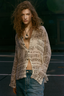

ResNet-50 output similarities:


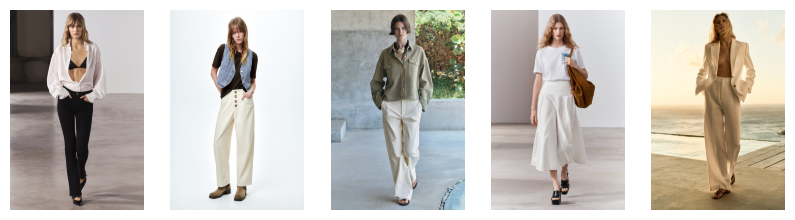

None
Custom model output similarities:


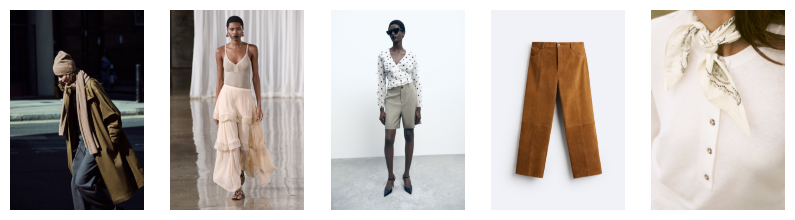

None


In [ ]:
url = eval_df.iloc[2]['images']
img = preprocess_image(url_to_Image(url))
print("Query image")
display(img)

print("ResNet-50 output similarities:")
print(get_most_similar_images(resnet50_model_collection, resnet50_model, url, n_images=5))

print("Custom model output similarities:")
print(get_most_similar_images(custom_model_collection, custom_model, url, n_images=5))

Query image


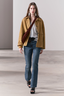

ResNet-50 output similarities:


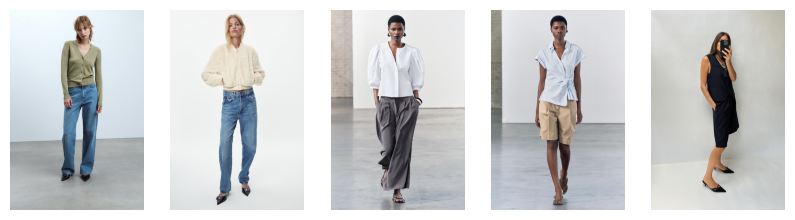

None
Custom model output similarities:


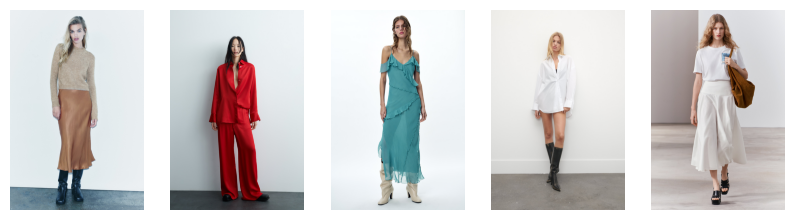

None


In [ ]:
url = eval_df.iloc[3]['images']
img = preprocess_image(url_to_Image(url))
print("Query image")
display(img)

print("ResNet-50 output similarities:")
print(get_most_similar_images(resnet50_model_collection, resnet50_model, url, n_images=5))

print("Custom model output similarities:")
print(get_most_similar_images(custom_model_collection, custom_model, url, n_images=5))

Query image


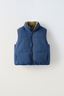

ResNet-50 output similarities:


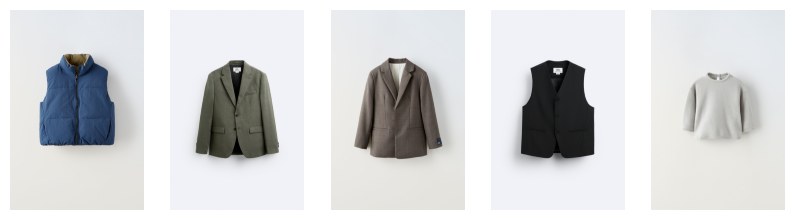

None
Custom model output similarities:


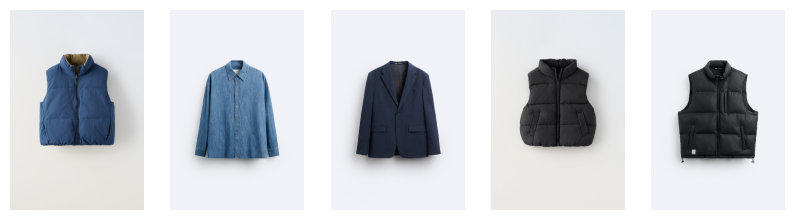

None


In [ ]:
url = eval_df.iloc[4]['images']
img = preprocess_image(url_to_Image(url))
print("Query image")
display(img)

print("ResNet-50 output similarities:")
print(get_most_similar_images(resnet50_model_collection, resnet50_model, url, n_images=5))

print("Custom model output similarities:")
print(get_most_similar_images(custom_model_collection, custom_model, url, n_images=5))

Query image


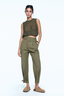

ResNet-50 output similarities:


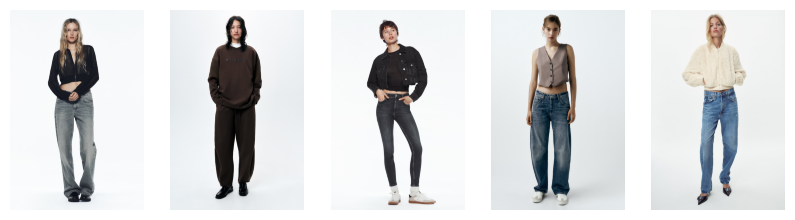

None
Custom model output similarities:


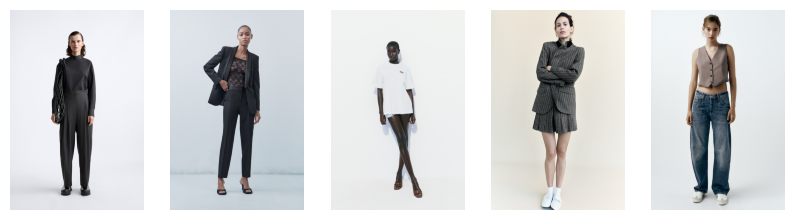

None


In [ ]:
url = eval_df.iloc[5]['images']
img = preprocess_image(url_to_Image(url))
print("Query image")
display(img)

print("ResNet-50 output similarities:")
print(get_most_similar_images(resnet50_model_collection, resnet50_model, url, n_images=5))

print("Custom model output similarities:")
print(get_most_similar_images(custom_model_collection, custom_model, url, n_images=5))

Query image


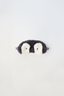

ResNet-50 output similarities:


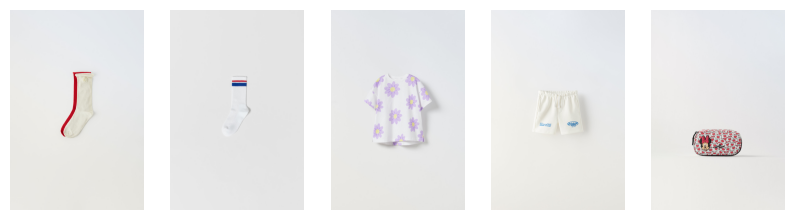

None
Custom model output similarities:


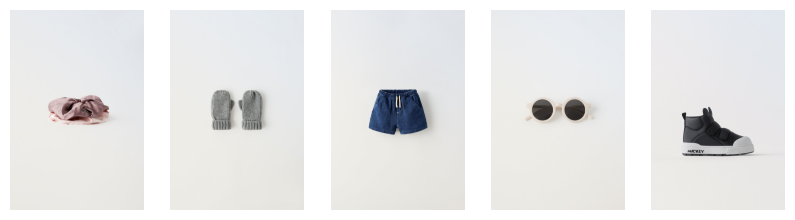

None


In [ ]:
url = eval_df.iloc[6]['images']
img = preprocess_image(url_to_Image(url))
print("Query image")
display(img)

print("ResNet-50 output similarities:")
print(get_most_similar_images(resnet50_model_collection, resnet50_model, url, n_images=5))

print("Custom model output similarities:")
print(get_most_similar_images(custom_model_collection, custom_model, url, n_images=5))